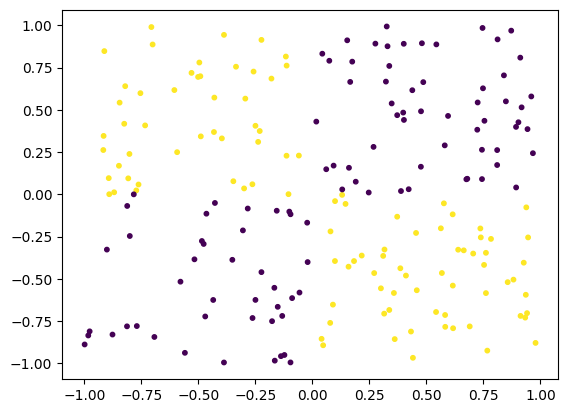

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

def generate_xor_data(num_samples):
    x = np.random.rand(num_samples, 2) * 2 - 1 
    y = np.logical_xor(x[:, 0] > 0, x[:, 1] > 0).astype(int)  
    return x, y

X_train, y_train = generate_xor_data(200)
X_test, y_test = generate_xor_data(200)

X_trainmlp, X_valmlp, y_trainmlp, y_valmlp = train_test_split(X_train, y_train, test_size=0.2)

plt.scatter(X_train[:,0], X_train[:,1], c = y_train, s = 10)
plt.show()

In [27]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

def train_model(model, criterion, optimizer, X, y, num_epochs=1000):
    for epoch in range(num_epochs):
        inputs = torch.tensor(X, dtype=torch.float32)
        labels = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def l1_regularization_loss(model, l1_lambda):
    return l1_lambda * sum(p.abs().sum() for p in model.parameters())


def train_model_with_l1(model, criterion, optimizer, X, y, l1_lambda=0.01, num_epochs=1000):
    for epoch in range(num_epochs):
        inputs = torch.tensor(X, dtype=torch.float32)
        labels = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss += l1_regularization_loss(model, l1_lambda)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate_model(model, X, y):
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = model(inputs)
        predicted = (outputs.numpy() > 0.5).astype(int)
        accuracy = np.mean(predicted.flatten() == y)
    return accuracy

def plot_decision_boundary(model, X, y, title, poly=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    if poly is not None:
        grid_poly = poly.transform(grid) 
        Z = model.predict(grid_poly).reshape(xx.shape)
    else:
        inputs = torch.tensor(grid, dtype=torch.float32)
        with torch.no_grad():
            Z = model(inputs).numpy().reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')


Test Accuracy - MLP: 0.9600



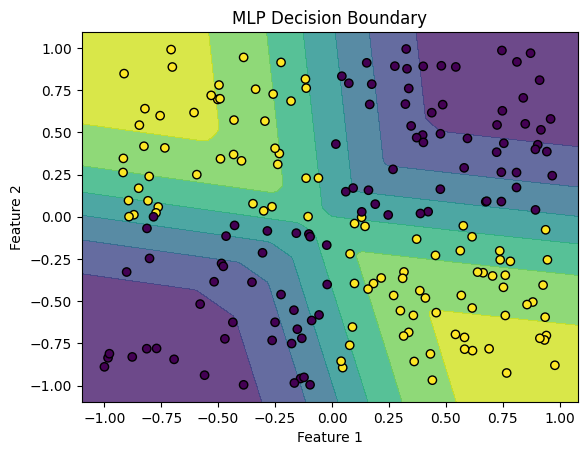

In [28]:
# MLP without regularization
input_size = 2
hidden_size = 8

mlp_model = MLP(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters())
train_model(mlp_model, criterion, optimizer, X_train_ml, y_train_ml)
accuracy_mlp = evaluate_model(mlp_model, X_test, y_test)
print(f"\nTest Accuracy - MLP: {accuracy_mlp:.4f}\n")

plot_decision_boundary(mlp_model, X_train, y_train, "MLP Decision Boundary")


Test Accuracy - MLP with L1 Regularization: 0.9350



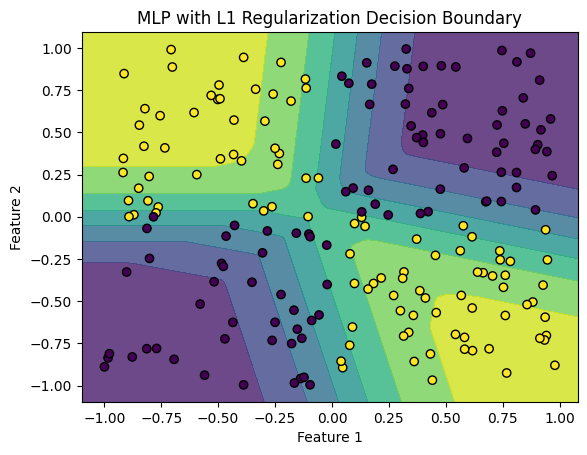

In [14]:
# MLP with L1 regularization
input_size = 2
hidden_size = 8

l1_model = MLP(input_size, hidden_size)
optimizer_l1 = optim.Adam(l1_model.parameters())  
train_model_with_l1(l1_model, criterion, optimizer_l1, X_train_ml, y_train_ml, l1_lambda=0.001)
accuracy_l1 = evaluate_model(l1_model, X_test, y_test)
print(f"\nTest Accuracy - MLP with L1 Regularization: {accuracy_l1:.4f}\n")

plot_decision_boundary(l1_model, X_train, y_train, "MLP with L1 Regularization Decision Boundary")


Test Accuracy - MLP with L2 Regularization: 0.9450



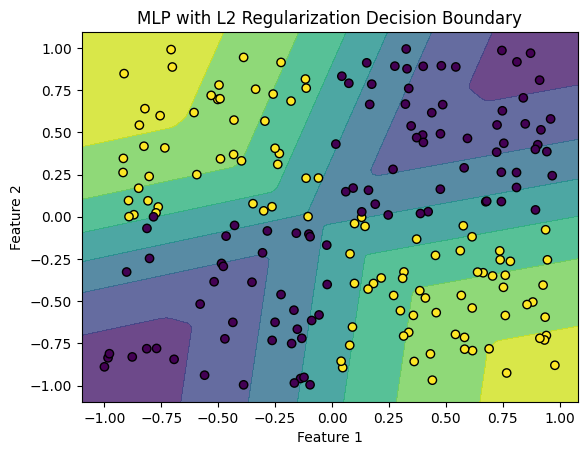

In [16]:
# MLP with L2 regularization
input_size = 2
hidden_size = 8

l2_model = MLP(input_size, hidden_size)
optimizer_l2 = optim.Adam(l2_model.parameters(), weight_decay=0.01)  
train_model(l2_model, criterion, optimizer_l2, X_train_ml, y_train_ml)
accuracy_l2 = evaluate_model(l2_model, X_test, y_test)

print(f"\nTest Accuracy - MLP with L2 Regularization: {accuracy_l2:.4f}\n")

plot_decision_boundary(l2_model, X_train, y_train, "MLP with L2 Regularization Decision Boundary")


Test Accuracy - Logistic Regression with Polynomial Features: 0.9350



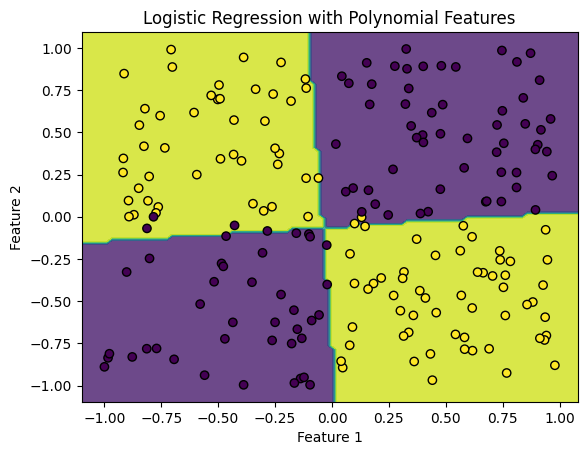

In [24]:
# Logistic Regression

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

log_reg = LogisticRegression(penalty='l2', C=0.6)  
log_reg.fit(X_train_poly, y_train)
accuracy_log_reg = log_reg.score(X_test_poly, y_test)

print(f"\nTest Accuracy - Logistic Regression with Polynomial Features: {accuracy_log_reg:.4f}\n")

plot_decision_boundary(log_reg, X_train, y_train, "Logistic Regression with Polynomial Features", poly = poly)